In [0]:
dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/df_sarimaa.csv

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Demand Forecasting") \
    .getOrCreate()

data_path = "dbfs:/FileStore/shared_uploads/podurikarthikeya69@gmail.com/df_sarimaa.csv" 
df_spark = spark.read.csv(data_path, header=True, inferSchema=True)
df_spark.show(5)


+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+--------+-----+-----+-----------+---------------------+-------------------------+
|    HostItemID|  Cost|  List|OnHand|MonthsNoSale|LastSaleDate|PriorYearSales|OnOrderQty|BestReorderPoint|SafetyStockLevel|MonthsWithAtLeastOneSale|Year|   Month|Sales|Lag_1|HolidayFlag|InventoryDiff_Reorder|InventoryDiff_SafetyStock|
+--------------+------+------+------+------------+------------+--------------+----------+----------------+----------------+------------------------+----+--------+-----+-----+-----------+---------------------+-------------------------+
|PMP*14680*2541|381.96|873.72|   184|          17|  2021-04-17|           217|        62|              74|              39|                       8|2021| January|   39|  NaN|          0|                  110|                       70|
|PMP*14680*2541| 385.0|873.72|   184|          17|  2021-04-

In [0]:
month_mapping = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12
}
df_pandas['Month'] = df_pandas['Month'].map(month_mapping)
df_pandas['Date'] = pd.to_datetime(df_pandas[['Year', 'Month']].assign(DAY=1))
df_pandas.set_index('Date', inplace=True)
df_demand = df_pandas[['Sales']]
print(df_demand.head())


            Sales
Date             
2021-01-01     39
2021-02-01     39
2021-03-01     22
2021-04-01     34
2021-05-01      0


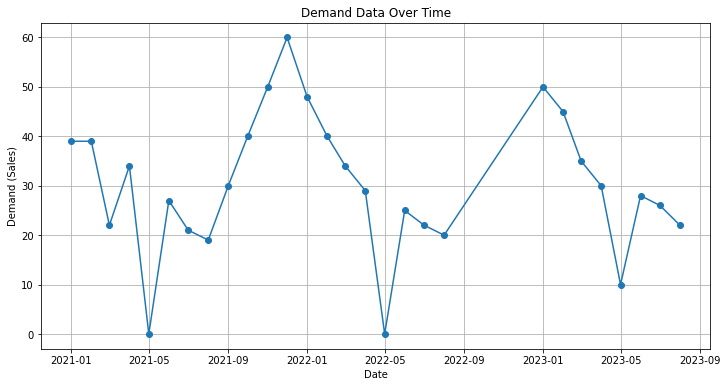

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

plt.figure(figsize=(12, 6))
plt.plot(df_demand.index, df_demand['Sales'], marker='o')
plt.title("Demand Data Over Time")
plt.xlabel("Date")
plt.ylabel("Demand (Sales)")
plt.grid()
plt.show()


In [0]:
train_size = int(len(df_demand) * 0.8)
train, test = df_demand[:train_size], df_demand[train_size:]

print(f"Training set size: {len(train)}")
print(f"Testing set size: {len(test)}")


Training set size: 22
Testing set size: 6


In [0]:
model = SARIMAX(train['Sales'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)
print(results.summary())

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   22
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -31.452
Date:                            Mon, 07 Oct 2024   AIC                             72.905
Time:                                    17:20:01   BIC                             73.891
Sample:                                         0   HQIC                            70.777
                                             - 22                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8272      0.789     -1.048      0.295      -2.374       0.720
ma.L1          0.2801      1.640   

/databricks/python/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


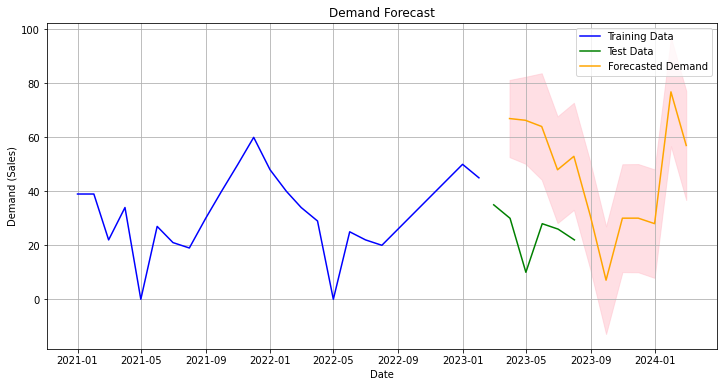

In [0]:
forecast_steps = 12
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=test.index[0], periods=forecast_steps, freq='M')
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)
conf_int = forecast.conf_int()
conf_int.index = forecast_index
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Sales'], label='Training Data', color='blue')
plt.plot(test.index, test['Sales'], label='Test Data', color='green')
plt.plot(forecast_series, label='Forecasted Demand', color='orange')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.5)
plt.title('Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Demand (Sales)')
plt.legend()
plt.grid()
plt.show()


In [0]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(test['Sales'], forecast_series[:len(test)]))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 32.83393745039436


In [0]:
import joblib
import mlflow
import mlflow.sklearn
joblib.dump(results, 'demand_forecast_model.pkl')

with mlflow.start_run():

    mlflow.log_param("model_type", "SARIMA")
    mlflow.log_metric("RMSE", rmse)
    mlflow.sklearn.log_model(results, "demand_model")

    mlflow.log_artifact('demand_forecast_model.pkl')

    print("Model and metrics logged to MLflow.")